<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture BNNs (MCMC)

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

## Outline for today

* How to interpret Bayesian neural network compared to deterministic NN?
* How to integrate the posterior through Markov Chain Monte Carlo?

**Reading material**: This notebook + (Bayesian perspective of ANNs in Chapter 29)

## Recap: ANN for regression with Gaussian prior
<img align=right src="./figures/recap.png" width=40%>


Assume a Gaussian prior  $\require{color} \color{red}p(z)$ on $\mathbf{w}$ and the MAP point estimate for an DNN

$$\require{color}
\hat{\mathbf{z}}_{\text{map}} = \underset{z}{\mathrm{argmin}}\left[-\log{p(\mathbf{y}=\mathbf{y}_n|\mathbf{x}=\mathbf{x}_n, \mathbf{z})} - \log{{\color{red}p(z)}}\right]$$


Performing the calculation, the point estimate when assuming a Gaussian prior becomes:

$$
\begin{align}
\hat{\mathbf{z}}_{\text{map}} = \underset{z}{\mathrm{argmin}}\left[\frac{1}{2} ||\mathbf{Y}-\mathbf{f}(\mathbf{X},\mathbf{z}) ||_2^2 + \alpha ||\mathbf{w}||_2^2\right]
\end{align}
$$

**Then, we can use sophisticated optimizers, as introduced in notebooks 25,26,27, for exploring the loss landscape (the right figure) to get a point estimation.**

## What if we want to get the posterior distributon of weights?

- Conceptually, from point estmation (DNN) to posterior distribution (BNN), we can inprepret we change the likelihood and prior from delta distribution to another distributions, like Gaussian distribution. 

 <img align=center src="./figures/dnnbnn.png" width=60%>


## What if we want to get the posterior distributon of weights?

- From an optimization view, instead of obtaining an optimum (shown in the lefr figure), it requires to integrate the whole loss (posterior distribution) landscape, as indicated in the second figure. 

 <img align=center src="./figures/OPTIMIZATION_VS_INFERENCE.png" width=60%>

## We then can formulate posterior with Bayes' rule?

\begin{align}
p\left( \mathbf{z} \mid \mathcal{D} \right) = \frac{p\left( \mathcal{D} \mid \mathbf{z} \right) p\left( \mathbf{z} \right)}{p\left( \mathcal{D} \right)} \propto p\left( \mathcal{D} \mid \mathbf{z} \right) \, p\left( \mathbf{z} \right)
\end{align}

- Likelihood: $
p\left( \mathcal{D} \mid \mathbf{z} \right)
= \mathcal{N}\!\left( \mathbf{Y} \,\middle|\, \mathbf{f}(\mathbf{X}, \mathbf{z}), \, \sigma^2 \mathbf{I} \right)
$, where $\sigma^2$ is the data noise.
- Prior:$
p\left( \mathbf{z} \right)
= \mathcal{N}\!\left( \mathbf{z} \,\middle|\, \mathbf{0}, \, \tau^2 \mathbf{I} \right)
$, where $\tau^2$ the variance of prior distribution.
- Log posterior can be derivated by:

\begin{align}
\log p\left( \mathbf{z} \mid \mathcal{D} \right) &= \log p\left( \mathcal{D} \mid \mathbf{z} \right) + \log p\left( \mathbf{z} \right)\\
&= \log \left[ \frac{\exp\left( -\frac{1}{2\sigma^2} 
    \left\| \mathbf{Y} - \mathbf{f}(\mathbf{X}, \mathbf{z}) \right\|_2^2 \right) }{(2\pi\sigma^2)^{n/2}} 
    \right]  + \log \left[ \frac{ \exp\left( -\frac{1}{2\tau^2} 
    \left\| \mathbf{w} \right\|_2^2 \right) }{(2\pi\tau^2)^{m/2}} \right] \\
&= -\frac{n}{2} \log(2\pi\sigma^2) 
   -\frac{1}{2\sigma^2} \left\| \mathbf{Y} - \mathbf{f}(\mathbf{X}, \mathbf{z}) \right\|_2^2  -\frac{m}{2} \log(2\pi\tau^2) 
   -\frac{1}{2\tau^2} \left\| \mathbf{w} \right\|_2^2
\end{align}

where $\frac{1}{2\tau^2}$ corresponds to the weight decay $\alpha$ in a deterministic setting

## How to integrate the posterior distribution? 

- The process of computing the posterior distribution over these variables based on observed data, following Bayes’ rule, is referred to as *inference*. 


- Once the likelihood, prior, and training data are fixed, the posterior distribution is also determined.


- On the other hand, changing any hyperparameter—such as replacing a Gaussian likelihood with another distribution or altering the data noise $\sigma^2$—will modify the posterior distribution. It is a higher-level Bayesian model training see Lecture 16.





### Markov Chain Monte Carlo (MCMC)


- A stochastic sampling method that constructs a Markov chain whose stationary distribution matches the target distribution $ p(\boldsymbol{\theta}) $. In the case of BNN, it is $p(\mathbf{z}|\mathcal{D})$.  
- It starts from an initial position $\boldsymbol{\theta}_0$ and generates candidate samples using a proposal distribution $ q(\boldsymbol{\theta}' \mid \boldsymbol{\theta}) $.  
- Each candidate is either accepted or rejected based on an acceptance rule (e.g., Metropolis–Hastings criterion), ensuring the chain explores the state space.  
- **Theoretical guarantee:** Under mild conditions (irreducibility, aperiodicity, detailed balance), the Markov chain converges to the target distribution as the number of iterations goes to infinity.  

 <img align=center src="./figures/ilustration_of_mcmc.png" width=30%> 



In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt

# define a dimensional PDF with two modes
class TargetDistribution:
    def __init__(self, 
                 w1=0.3,
                 w2=0.7, 
                 mu1=-2, 
                 sigma1=1,
                 mu2=2,
                 sigma2=1) -> None:
        self.w1 = w1
        self.w2 = w2
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2

    def pdf(self, x) -> float:
        return self.w1 * self.gaussian(x, self.mu1, self.sigma1) + \
            self.w2 * self.gaussian(x, self.mu2, self.sigma2)

    def plot_pdf(self):
        fig, ax = plt.subplots(figsize=(5, 4))
        x = np.linspace(-10, 10, 1000)
        y = self.pdf(x)
        ax.plot(x, y)
        ax.set_xlabel('x')
        ax.set_ylabel('pdf')
        plt.show()

    @ staticmethod
    def gaussian(x, mu, sigma) -> float:
        return 1.0/(np.sqrt(2 * np.pi)) * np.exp(- ( x- mu)**2 / 2*sigma**2)
    

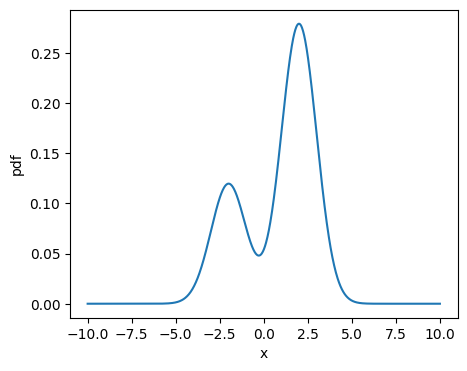

In [2]:
target  = TargetDistribution()

target.plot_pdf()

In [3]:
class MetropolisHastings:
    def __init__(self,  target_distribution, num_samples=2000,  burn_in=10,  step_size=5.0) -> None:
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.step_size = step_size
        self.target_distribution = target_distribution
    def run(self, num_trials=1):
        self.trial_samples = []
        self.acceptance_rate = []
        for trial in range(num_trials):
            x = np.random.normal(loc=0, scale=1) 
            samples = []
            accept = 0
            for i in range(self.num_samples + self.burn_in):
                proposed_x = x + np.random.normal(loc=0, scale=1)  * self.step_size # Propose a new sample using random walk Metropolis-Hastings
                prop_x = self.target_distribution.pdf(proposed_x) # Compute the acceptance probability
                prop_curr = self.target_distribution.pdf(x)
                log_alpha = np.log(prop_x) - np.log(prop_curr) # calculate acceptation rate (to improve numerical stability)
                p_accept = min(1.0, np.exp(log_alpha))
                if np.random.rand(1).item() < p_accept:# Accept or reject the proposal
                    x = proposed_x
                    accept += 1
                if i >= self.burn_in:
                    samples.append(x)
            print(f'Acceptance rate of trial {trial}: {accept/self.num_samples}')
            self.acceptance_rate.append(accept/self.num_samples)
            self.trial_samples.append(samples)
        return self.trial_samples
    def plot_trials(self):
        fig, ax = plt.subplots(figsize=(5, 4))
        for i, samples in enumerate(self.trial_samples):
            ax.hist(samples, bins=30, density=True, alpha=0.7, label=f'Trial {i+1}')
        x = np.linspace(-10, 10, 1000)
        ax.plot(x, self.target_distribution.pdf(x), 'r--', label='True PDF')
        ax.legend(loc='upper left')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Sample')
        plt.show()

Acceptance rate of trial 0: 0.3665
Acceptance rate of trial 1: 0.3735
Acceptance rate of trial 2: 0.373
Acceptance rate of trial 3: 0.358
Acceptance rate of trial 4: 0.3725


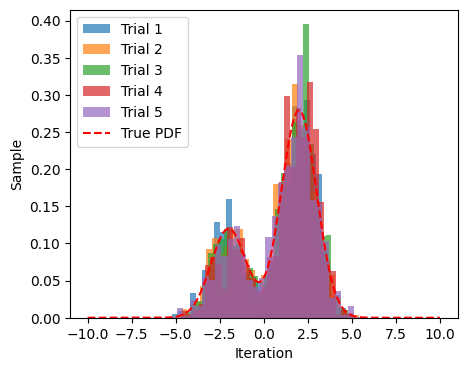

In [4]:
# play with burn_in, step_size, number_samples of RWMH method, which are the tunable parameters of RWMH
MH = MetropolisHastings(target_distribution=target,
                        num_samples=2000, 
                        burn_in=10, 
                        step_size=5.0)
results = MH.run(num_trials=5)

MH.plot_trials()


## Hamiltonian Monte Carlo (HMC)
- One fatal drawback of RWMH algorithm is that the random walk procedure prevents the scalability.

- Hamiltonian Monte Carlo (Neal 2012) improves the convergence, with embedding the concept of Hamitonian mechanics. 



<img src="figures/hmc.png" title="Hamiltonian mechanics" width="30%" align="right">
<!-- <img align=center src="./figures/hmc.png" width=20%>  -->
A Hamiltonian mechanical system can be imagined as a ball rolling in a frictionless bowl:
$$
\mathcal{H}\left(\boldsymbol{\theta}, \mathrm{v} \right) =
   \mathcal{\varepsilon(\boldsymbol{\theta})} + \mathcal{K}(\mathrm{v})
$$

- potential energy: $\mathcal{\varepsilon(\boldsymbol{\theta})} = - \log \, p(\boldsymbol{\theta})$

- kinetic energy: $\mathcal{K}(\mathrm{v}) = \frac{1}{2}\mathrm{v}^{T} {\Sigma}^{-1} \mathrm{v}$

where ${\Sigma}$ is the mass matrix.

**Key Idea**
- Uses Hamiltonian dynamics to propose new states by simulating trajectories shown in the figure
- This **efficiently explores** the target distribution and **increases acceptance rates** by following energy-preserving paths.



### How to update position and velocity within Hamiltonian system: 

- **Euler's method**

$$\mathrm{v}_{t+1} = \mathrm{v}_{t} + \eta \frac{d\mathrm{v}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{v}_{t}-\eta \frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} = \mathrm{\theta}_{t} + \eta \frac{d\mathrm{\theta}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{\theta}_{t}-\eta \frac{\partial \mathcal{K}(\mathrm{v}_t)}{\partial \mathrm{v}}$$

- **Modified Euler's method: _Improve accuracy_**

$$\mathrm{v}_{t+1} = \mathrm{v}_{t} + \eta \frac{d\mathrm{v}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{v}_{t}-\eta \frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} = \mathrm{\theta}_{t} + \eta \frac{d\mathrm{\theta}(\mathrm{\theta}_t, \mathrm{v}_{t+1})}{dt}= \mathrm{\theta}_{t}-\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+1})}{\partial \mathrm{v}}$$


### How to update position and velocity within Hamiltonian system: 

- **Leapfrog method:** *further improve the accuracy, with multiple leapfrog steps update*

$$\mathrm{v}_{t+\frac{1}{2}} =\mathrm{v}_{t}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} =  \mathrm{\theta}_{t}+\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+\frac{1}{2}})}{\partial \mathrm{v}}$$

$$\mathrm{v}_{t+1} =\mathrm{v}_{t+\frac{1}{2}}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_{t+1})}{\partial \mathrm{\theta}} $$

In [10]:
class HamiltonianMonteCarlo:
    """ Hamiltonian Monte Carlo algorithm via pytorch
    """
    
    def __init__(self, 
                target_distribution,
                proposed_mu=0,
                proposed_var=1,
                num_samples=2000, 
                burn_in=10, 
                step_size=0.1, 
                leapfrog_steps=10,
                num_steps=10) -> None:
        """ Initialize the Hamiltonian Monte Carlo algorithm

        Parameters
        ----------
        target_distribution : class
            target distribution
        num_samples : int, optional
            number of samples to generate, by default 2000
        burn_in : int, optional
            burn-in period, by default 10
        step_size : float, optional
            step size of the random walk, by default 0.1
        leapfrog_steps : int, optional
            number of leapfrog steps, by default 10

        """
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.step_size = step_size
        self.leapfrog_steps = leapfrog_steps

        # information about the target distribution
        self.target_distribution = target_distribution

        # information about the proposal distribution
        self.proposed_mu = proposed_mu
        self.proposed_var = proposed_var
        

    def hmc_step(self, x) :
        """ Hamiltonian Monte Carlo step """
        x_0 = np.copy(x)
        p_proposal = np.random.normal(self.proposed_mu,
                                      self.proposed_var)
        p_0 = p_proposal
        # Make a half step for momentum at the beginning
        p_proposal = p_proposal - self.step_size * self.target_distribution.grad_neg_log_pdf(x) / 2
        # Alternate full steps for position and momentum
        for i in range(self.leapfrog_steps):
            # Make a full step for the position
            x = x + self.step_size * p_proposal
            # Make a full step for the momentum, except at end of trajectory
            if i != self.leapfrog_steps - 1:
                p_proposal = p_proposal - self.step_size * self.target_distribution.grad_neg_log_pdf(x)
        # Make a half step for momentum at the end
        p_proposal = p_proposal - self.step_size * self.target_distribution.grad_neg_log_pdf(x) / 2
        # Negate momentum at end of trajectory to make the proposal symmetric
        p_proposal = -p_proposal
        # Evaluate potential and kinetic energies at start and end of trajectory
        current_U = self.target_distribution.neg_log_pdf(x_0)
        current_K = p_0 ** 2 / 2
        proposed_U = self.target_distribution.neg_log_pdf(x)
        proposed_K = p_proposal ** 2 / 2
        # Accept or reject the state at the end of the trajectory
        if np.random.uniform() < np.exp(current_U - proposed_U + current_K - proposed_K):
            return x , 1 # accept
        else:
            return x_0, 0 # reject
    
    def _hmc_single_run(self):
        samples = []
        accept = 0
        x = np.random.normal(loc=0, scale=1)
        for i in range(self.num_samples + self.burn_in):
            x, acc = self.hmc_step(x)
            if i >= self.burn_in:
                accept += acc
                samples.append(x)
        return samples, accept/self.num_samples
    
    def run(self, num_trials=1):
        self.trial_samples = []
        self.acceptance_rate = []
        for trial in range(num_trials):
            samples, acc_rate = self._hmc_single_run()
            print(f'Acceptance rate of trial {trial}: {acc_rate}')
            self.trial_samples.append(samples)
            self.acceptance_rate.append(acc_rate)
        return self.trial_samples

    def plot_trials(self):
        fig, ax = plt.subplots(figsize=(5, 4))
        for i, samples in enumerate(self.trial_samples):
            ax.hist(samples, bins=30, density=True,
                     alpha=0.7, label=f'Trial {i+1}')
        # plot the pdf of the target distribution
        x = np.linspace(-10, 10, 1000)
        ax.plot(x, self.target_distribution.pdf(x), 'r--', label='True PDF')
        ax.legend(loc='upper left')
        ax.grid('--')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('PDF')
        plt.show()

In [11]:

# use autograd to get the autodiff
from autograd import grad


class TargetDistribution4HMC(TargetDistribution):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    
    def neg_log_pdf(self, x):
        return -np.log(self.pdf(x))
    
    def grad_neg_log_pdf(self, x):
        return grad(self.neg_log_pdf)(x)

target = TargetDistribution4HMC()
    


Acceptance rate of trial 0: 0.9985
Acceptance rate of trial 1: 0.9985
Acceptance rate of trial 2: 0.9975
Acceptance rate of trial 3: 0.997
Acceptance rate of trial 4: 0.998


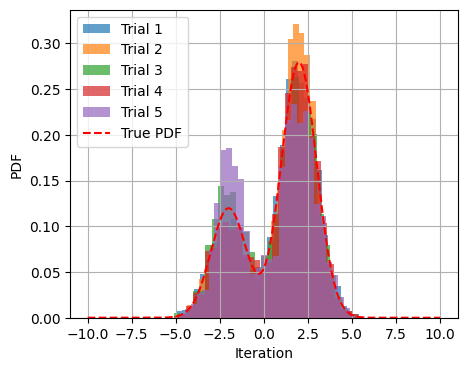

In [12]:
# run the HMC algorithm, play with parameters 
HMC = HamiltonianMonteCarlo(target_distribution=target,
                            proposed_mu=0,
                            proposed_var=1,
                            num_samples=2000, 
                            burn_in=10, 
                            step_size=0.2, 
                            leapfrog_steps=20)
results = HMC.run(num_trials=5)
HMC.plot_trials()

### See you next class

Have fun!